# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocs you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [12]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [13]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [14]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [15]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


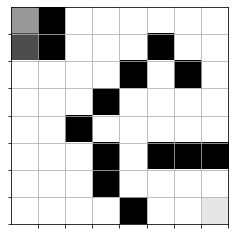

In [16]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [17]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [18]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [19]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [20]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    for epoch in range(n_epoch):
    #    Agent_cell = randomly select a free cell
        Agent_cell = random.choice(qmaze.free_cells)
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
        qmaze.reset(Agent_cell)
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
        envstate = qmaze.observe()
        
    #    While state is not game over:
        game_status = 'not_gameOver'
        while game_status=='not_gameOver':
        #        previous_envstate = envstate
            prev_envstate = envstate
            q = model.predict(prev_envstate)
        #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
            action = random.choice(actions_dict)
        #        envstate, reward, game_status = qmaze.act(action)
            envstate, reward, game_status = qmaze.act(action)
        #    Hint: Review the act method in the TreasureMaze.py class.
            actionInt=list(actions_dict.keys())[list(actions_dict.values()).index(action)]
        #        episode = [previous_envstate, action, reward, envstate, game_status]
            episode = [prev_envstate, actionInt, reward, envstate, game_status]
        #        Store episode in Experience replay object
        #    Hint: Review the remember method in the GameExperience.py class.
            experience.remember(episode)
        #        Train neural network model and evaluate loss
        #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
        #          to train the model. You can call model.evaluate to determine loss.
            inputs,targets = experience.get_data()
            model.fit(inputs, targets)
        #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.
        if win_rate > 0.9 and completion_check(model, qmaze):
            epoch = i
            print(i)

    #Print the epoch, loss, episodes, win count, and win rate for each epoch

            dt = datetime.datetime.now() - start_time
            t = format_time(dt.total_seconds())
            template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
            print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
            # We simply check if training has exhausted all free cells and if in all
            # cases the agent won.
            if win_rate > 0.9 : epsilon = 0.05
            if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
                print("Reached 100%% win rate at epoch: %d" % (epoch,))
                break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

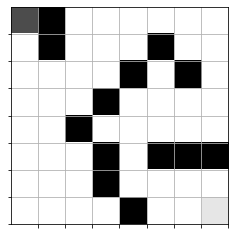

In [21]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [ ]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch 1/1
1/1 [==============================] - 1s 538ms/step - loss: 0.5003
Epoch 1/1
2/2 [==============================] - 0s 1ms/step - loss: 0.1468
Epoch 1/1
3/3 [==============================] - 0s 667us/step - loss: 0.0683
Epoch 1/1
4/4 [==============================] - 0s 747us/step - loss: 0.0364
Epoch 1/1
5/5 [==============================] - 0s 595us/step - loss: 0.0159
Epoch 1/1
6/6 [==============================] - 0s 661us/step - loss: 0.0096
Epoch 1/1
7/7 [==============================] - 0s 569us/step - loss: 0.0098
Epoch 1/1
8/8 [==============================] - 0s 374us/step - loss: 0.0125
Epoch 1/1
9/9 [==============================] - 0s 443us/step - loss: 0.0158
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 0.0188
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 0.0225
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 0.0153
Epoch 1/1
10/10 [==============================] - 0s 200us/

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.0527e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.2317e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.7855e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.3540e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1176e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.5801e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4722e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9913e-04
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.7028e-04
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 2.6510e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.7593e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 4.1135e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.3024e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.9152e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.1517e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5116e-04
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.0140e-04
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.3562e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.6219e-04
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 2.4166e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.8137e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6518e-04
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 2.51

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.3011e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0201e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.3012e-04
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.9678e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.7531e-04
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.0542e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.4354e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.8363e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2226e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.1870e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9134e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.6

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.8103e-04
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.7892e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.5362e-04
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.6810e-04
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 5.9709e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5549e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.4949e-04
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.5457e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.3814e-04
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.9393e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.5483e-04
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.2670e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4504e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.6428e-04
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 7.1679e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0980e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.2945e-04
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.6304e-04
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.9403e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.0634e-04
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.3958e-04
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 2.4216e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2660e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.8191e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.8871e-04
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.8173e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.1795e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.5510e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.5104e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8334e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.6705e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.1654e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7538e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9261e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.2303e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7547e-04
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.9639e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.4499e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.3563e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.1165e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.3189e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.7148e-04
Epoch 1/1
10/10 [==============================] - 0s 195us/step - loss: 1.8550e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5493e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.1

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.2417e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.9603e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0668e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.7173e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.4454e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8563e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0248e-04
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.5184e-04
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 9.7148e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4215e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3569e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.0256e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.9735e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1723e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0488e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.6263e-04
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.6455e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.4886e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.6191e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3103e-04
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.0792e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2168e-04
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.1

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.3915e-04
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.3340e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4006e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.5861e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.2576e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.8039e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1416e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.4823e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.5943e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.8042e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9269e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.3259e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6590e-04
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.8051e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9794e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1591e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.5047e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.7939e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6248e-04
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 6.8720e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7823e-04
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1219e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.8

Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.9583e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.7512e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.6988e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.5171e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.2650e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.6473e-05
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 4.2757e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.3300e-04
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.0830e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.0042e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3735e-04
Epoch 1/1
10/10 [==============================] - 0s 207us/step - loss: 9.5

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7452e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4577e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0857e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1253e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.3964e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.5627e-04
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 2.1051e-04
Epoch 1/1
10/10 [==============================] - 0s 106us/step - loss: 1.5898e-04
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 7.3024e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.9760e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.0865e-04
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.5

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1536e-04
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.2870e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.8155e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6969e-04
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.5843e-04
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.0684e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0272e-04
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.8520e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4142e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.8372e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3059e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.0600e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3370e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.4414e-04
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.6316e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9268e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2861e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3947e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5138e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.1276e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.0159e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0145e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.4

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9862e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.6014e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.1207e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.2801e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.3279e-04
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.2648e-04
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 3.6074e-04
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.6295e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.2751e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.0805e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5989e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.4

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.5218e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2428e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7223e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3493e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.0378e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.0227e-05
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1580e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.4082e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.3421e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1866e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.3420e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.5079e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.8085e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.4753e-04
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 4.1611e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.3750e-05
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 1.2568e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.8614e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.4819e-05
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.1935e-04
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0099e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 7.2939e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.1

Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 5.1054e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0427e-04
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 7.8639e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.0817e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.1760e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.5569e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2317e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.5028e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.1502e-05
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 6.3313e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.3303e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.2

Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.3945e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.6198e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.0605e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.3442e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.5055e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.1723e-05
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 4.7407e-05
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.5679e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3927e-04
Epoch 1/1
10/10 [==============================] - 0s 210us/step - loss: 9.9862e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.5238e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.6

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.1461e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.8832e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.9573e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.3820e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0549e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4478e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2224e-04
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 7.0618e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.3594e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.4976e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2307e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.5

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3543e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.2482e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.4720e-05
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.9883e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0185e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.8082e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.0706e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.1233e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4414e-05
Epoch 1/1
10/10 [==============================] - 0s 208us/step - loss: 3.3693e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.2814e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.0411e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.2786e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.2056e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.6431e-05
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 8.6635e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9192e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.3452e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.7244e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.4807e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.2074e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.5287e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.4

Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.1614e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1020e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.1304e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 8.6012e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.0587e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.1465e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2019e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4652e-05
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.1666e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.3963e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.7171e-04
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.7110e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.4293e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.8114e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.5107e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 7.1754e-05
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 7.3564e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.1265e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.1044e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.0674e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.3659e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.9611e-05
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.5295e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.6291e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7672e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.5306e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.0153e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.1758e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.0661e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.3399e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.3867e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.9126e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.8751e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.5437e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3893e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.9755e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.1119e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 6.3696e-05
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 8.1486e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.3402e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.2437e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1406e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.3583e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.1982e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 7.6009e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.9716e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5366e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.5876e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.8787e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.6212e-05
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 6.4412e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.6860e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.2739e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.8622e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5603e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.12

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.9229e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.8646e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.7058e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.3770e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.5358e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.9189e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.5993e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.2892e-05
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 4.4020e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.0077e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9489e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.03

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.3945e-05
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9414e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.8180e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.0176e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6611e-05
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.6653e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.6721e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1551e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1629e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6784e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.8582e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9078e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.6793e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4255e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.0416e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.9723e-05
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.0735e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6441e-05
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 4.0591e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.5034e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.7277e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.3797e-05
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.3

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.7975e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6916e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 9.0832e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.9045e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 3.5807e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.9999e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0058e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.1723e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.8013e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.2495e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.6583e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.0923e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.8488e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.8319e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.4317e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.7210e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.5846e-05
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.1304e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.2741e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.9356e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3571e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.7600e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.1

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1370e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.9968e-05
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 7.7911e-05
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 8.2264e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.4765e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.7456e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.0118e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.5187e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.8445e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.2196e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.1513e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.2

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.4309e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.6293e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.7860e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6219e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.5307e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9456e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.4012e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.9926e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4388e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.1399e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.6746e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.5

Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.7470e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.0006e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 8.0514e-05
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.7445e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4421e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.6327e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.1808e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.1593e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 7.5713e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.8838e-05
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.3625e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.3

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.9464e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4628e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.8264e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 4.3124e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1407e-04
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.3115e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.9061e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.8386e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.7045e-05
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.3664e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.0109e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.6

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3628e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.3170e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.9613e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.5116e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.8164e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2350e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.0651e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5788e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.2404e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3857e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.8578e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.1

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.7358e-05
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 2.6385e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.3371e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.3663e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.7518e-05
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.0810e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.1998e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.8955e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 3.8066e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.5296e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.1437e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.38

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.3379e-05
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 3.2620e-05
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.1893e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2475e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.7437e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6100e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.3648e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6850e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.3705e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.7219e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.0571e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.08

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.9213e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6587e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3538e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4876e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.2240e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.6591e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1175e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8813e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6765e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2967e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.6918e-05
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.3248e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.4673e-05
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.6162e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.1096e-05
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.7753e-06
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 2.3697e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.5315e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.4786e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2852e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0876e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.4152e-06
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 1.93

Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 3.9285e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.9439e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.0876e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.8501e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.5864e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.3649e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3221e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2218e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.6626e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4771e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.0365e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.8

Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.0961e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.8456e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.2910e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.0824e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4644e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1867e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7071e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3901e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.9795e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.0712e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7535e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.4

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.3572e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9995e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.8410e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.7915e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.3042e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 7.3074e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8537e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.6847e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 8.8859e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.0316e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6965e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.3211e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.4514e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4953e-05
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 2.9749e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8605e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2143e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4518e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4460e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.8189e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.9055e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.9584e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5717e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.0778e-06
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 8.5328e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.6981e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.2147e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 7.0654e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.9079e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4516e-05
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.2408e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.6651e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.2692e-05
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 9.7

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.1408e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6130e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 4.5766e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0587e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2688e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8043e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2985e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.0307e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.4177e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5624e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.4849e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.5

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.4355e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7894e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.6566e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6605e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2791e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.0824e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3699e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.2836e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.7302e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.2271e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2511e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.0721e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.9306e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.9648e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.2308e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.3480e-05
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 6.0305e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.5773e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.6057e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.6431e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.5620e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1435e-05
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 1.5481e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.1460e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.6315e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.1106e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.6782e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.8863e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.7219e-04
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.6933e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.8070e-04
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5175e-04
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.0410e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.2

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.8626e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.9190e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.7061e-05
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.0377e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.0311e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8804e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 8.6745e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5943e-05
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 2.1521e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6484e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.1783e-05
Epoch 1/1
10/10 [==============================] - 0s 98us/step - loss: 1.143

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 7.1559e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.3147e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7195e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5348e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.4748e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.3391e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.4896e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4609e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.4539e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.9440e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 7.3930e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.3

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.5825e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 1.3661e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.3238e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 5.8755e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.9668e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.4449e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 3.9255e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.0334e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2320e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0574e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.8020e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.6282e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.8164e-05
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.3764e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.6587e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 3.8179e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.8586e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6028e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2313e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.6351e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8223e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.8696e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0146e-04
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4820e-04
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.9656e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.6475e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.9645e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8932e-04
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6093e-04
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 7.9989e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.0229e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.9143e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.1317e-05
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4563e-05
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 4.5069e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5917e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5136e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.6113e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6256e-05
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.8615e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 4.0540e-05
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 3.1157e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.8655e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.8126e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.8998e-05
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 3.4661e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.8639e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.1812e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3404e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.8295e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.7070e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.2785e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6646e-05
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.0295e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0150e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.8642e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.7345e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.5757e-05
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 4.3397e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.8539e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.8425e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.8056e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.1426e-05
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.0623e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.8266e-05
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.6404e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.2

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5765e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.8382e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6094e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.4813e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.2860e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8078e-05
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.1298e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.2804e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6611e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.2110e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4019e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.0

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.5910e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6241e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3952e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.9127e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6974e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.5495e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9199e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.4706e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.3887e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.6701e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.1167e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0

Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 1.4250e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2037e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4929e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.8144e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.7311e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.5455e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.3079e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5734e-06
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 7.4302e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.6487e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3822e-05
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.16

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.5444e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.6594e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4274e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 8.6806e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.7237e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1115e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.1104e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4421e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3293e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 8.0780e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 1.0913e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.4

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.8357e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.2834e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7924e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.8134e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.4460e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.2113e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.7886e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.7246e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 4.8766e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.4944e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.5534e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.7604e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3944e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.1723e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 4.3405e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3627e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.3852e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2576e-05
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 8.0426e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.0752e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.4617e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.7145e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 7.3255e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.6258e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2807e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.2265e-06
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.7516e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.5818e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.5663e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.2059e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.2059e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.2817e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.8243e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.4

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2447e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 6.3305e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1146e-05
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.5189e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8276e-05
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.7457e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 9.5514e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.1082e-06
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 1.3289e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.0433e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3876e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.01

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.0001e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0021e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 5.2100e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.5058e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.7800e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1756e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.3517e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.7491e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.2340e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.1118e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.5660e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.6

Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4990e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.3770e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.7782e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.7515e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.5538e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7474e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.9717e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.9203e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.2832e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0282e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.1864e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.3

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.1996e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.3894e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.5263e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.7014e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.9118e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.9281e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.8073e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9601e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.4365e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.0196e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.2452e-06
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.6

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.3513e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.6853e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.2791e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.6758e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0972e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.1628e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.7266e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.7397e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.6299e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8768e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9010e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.6

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.3732e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.9575e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.7069e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.6797e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.9337e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.6489e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 6.5364e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 3.3738e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.1601e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.9691e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.4931e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 6.2

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.0709e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 3.2979e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.7277e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.2115e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.4545e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.3908e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.1380e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.1906e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3829e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0047e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1729e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.9202e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.2399e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.9903e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.0626e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.9046e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.4461e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.5178e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.0877e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.1877e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2347e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.1304e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 6.5

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.0317e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7772e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.6193e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 9.8281e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.1564e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.9929e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.4851e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.8093e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 5.4576e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.3951e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.2714e-06
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 3.9

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.5562e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.9489e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 6.4986e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 7.2467e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6035e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.5711e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3825e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.6491e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.3105e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.9427e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.5035e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.4649e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5174e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.1011e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.0033e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0710e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.5373e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.2647e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 5.1408e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.8200e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.8366e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.5728e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.3

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.5430e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.5997e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.5093e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.1362e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.8855e-06
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 2.6813e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.8174e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.4553e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.1817e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 7.2387e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3674e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.2

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.0572e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.9454e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2647e-05
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.7419e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.9315e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5948e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 2.9031e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.8988e-06
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.4506e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.5596e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.7479e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.9958e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6519e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1375e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2086e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.7591e-06
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 2.9722e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.3445e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9683e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0576e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.9789e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.3290e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.2

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.6192e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 7.6894e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.3818e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.8354e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.7007e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.6291e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.0586e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.6301e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.9703e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5665e-06
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 6.6733e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.7962e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8393e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.0472e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.0349e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.7695e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 5.0894e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.0300e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.2330e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.8104e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.4393e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.5102e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 3.7

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.5550e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.4054e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5652e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4236e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3705e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4082e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.8608e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.3804e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6848e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.8456e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2619e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.0

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.9754e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.7227e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.7336e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1211e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 8.8379e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.0942e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.6514e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5731e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.3123e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7481e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6531e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.6

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.4044e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.2778e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9649e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.5007e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7363e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2017e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6400e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9040e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1246e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.3165e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.6651e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.4

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.4554e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.5883e-06
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 2.0371e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.0655e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.9119e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.9292e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.0581e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.6732e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.6147e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.9336e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 1.9990e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.16

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.4370e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2487e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 3.9278e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.0425e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.9476e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2451e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.9615e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.9203e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.3089e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6167e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.6187e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.5

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.5927e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.1627e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.1563e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 8.8304e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.6956e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.0300e-06
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.1893e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.7215e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.0863e-07
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.9721e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.6772e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.3

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.0741e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.7320e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.3645e-06
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 8.9972e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3318e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.5762e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.5441e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.5262e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.2965e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.6390e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.7166e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2972e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.3752e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.2484e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6050e-07
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 2.4922e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7645e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.6902e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 2.1273e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1756e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.8267e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.0450e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.3290e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.0241e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0043e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0210e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2831e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.5600e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4687e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2023e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5591e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6255e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.7999e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.4922e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 2.2575e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 8.7864e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.8227e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.0538e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.0159e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.7164e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3966e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 2.0353e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.1459e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.2019e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.3

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2033e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 3.8284e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.1051e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 8.8211e-06
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 9.1314e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.0999e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.2100e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.9812e-06
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 8.5450e-06
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.0597e-05
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.1233e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.95

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.8105e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.4610e-05
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 8.7122e-06
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 5.8151e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.4954e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4247e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.5607e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 5.1031e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.0219e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 8.6629e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 7.6008e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6

Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 7.6881e-07
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.5960e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 7.9536e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.3226e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.2774e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.7049e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0971e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.0426e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2507e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.9153e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0191e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1210e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5154e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6856e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.0697e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 3.2697e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.0107e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.1231e-06
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.8691e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1845e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.7750e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.8135e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 4.1

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.8882e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.0883e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.6364e-07
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 6.5068e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.7206e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.3181e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5176e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.7574e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.9078e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.4166e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0964e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.08

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.6532e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.8028e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 8.4756e-07
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 9.3664e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.0434e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2418e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2243e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4223e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4196e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.4619e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 7.3127e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.7

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4089e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.5388e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.9763e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 5.4625e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.6585e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2359e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.1621e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.1399e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.8067e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.4472e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.9428e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.5

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.5726e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.6034e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.9744e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.8187e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.6552e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.4796e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5298e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1824e-06
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 9.3414e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3257e-05
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.7114e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.6

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1024e-05
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.7956e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.4135e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.2155e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.0812e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.4884e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.5860e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.7233e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.0984e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.9310e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.6377e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.4293e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 7.8941e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1497e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0935e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.3782e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.3874e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.0995e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.9169e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4266e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.3381e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.3720e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.9

Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 4.9669e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.1127e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.9125e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0923e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6312e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.3512e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.8128e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.1431e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.5588e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6505e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.2731e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.19

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2617e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5151e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.4807e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.4512e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 8.4246e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8047e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5714e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.0999e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.1333e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 8.5878e-07
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 7.9818e-07
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.5099e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0474e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.4607e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2769e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5492e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 4.0890e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.3117e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.8886e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6825e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9590e-07
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.1516e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.5563e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.0390e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4400e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.6660e-07
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.4292e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6151e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 2.5547e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.4710e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4863e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.6577e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.1823e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.7

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.5647e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8489e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2883e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.5834e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7406e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1063e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.4016e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.8258e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 6.5375e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.8863e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0233e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.5

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0123e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.9614e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.3023e-06
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 1.7514e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.9127e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 3.7188e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.1394e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.5800e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.7546e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.7719e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 7.4803e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 8.0022e-08
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.8017e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 4.8058e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.3278e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.4039e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.0151e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.4887e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.4313e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9245e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.2898e-07
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.6516e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 7.6

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.2355e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6559e-06
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.2395e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.1338e-06
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.5770e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.7588e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 6.3754e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.2832e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6148e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3396e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.5275e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.4

Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 7.2469e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.9860e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.1605e-07
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 7.9824e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.3784e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.4607e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.9530e-07
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 5.8398e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.8093e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.9378e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.9847e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.0701e-06
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 9.0693e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3635e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.7465e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.6193e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.7677e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.8251e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0023e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9746e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6354e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.7519e-06
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 7.435

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0083e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 2.1400e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.6182e-07
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 4.1202e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5129e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5942e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.6993e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.9000e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.2848e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1039e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.7205e-07
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.8797e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.5593e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.2332e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 4.0239e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8121e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1812e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.6076e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.0950e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.3625e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.1158e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5252e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.0

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.9579e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4052e-07
Epoch 1/1
10/10 [==============================] - 0s 211us/step - loss: 6.2638e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.6114e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 1.8415e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.9334e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.7227e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.3810e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4959e-07
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.1275e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.8892e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 259us/step - loss: 4.2102e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.0033e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.5851e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.6080e-06
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 2.2081e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.9572e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0831e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.7067e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.1548e-06
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 5.0839e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.1851e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9

Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 3.1051e-05
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.1365e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.0786e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6948e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4739e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.1104e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2139e-05
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2594e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.5056e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.1447e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4712e-05
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.0

Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.9141e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.0924e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.2586e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8493e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.3106e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.7917e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.7704e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.0374e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.5864e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.1345e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 1.7669e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.1407e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.4214e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.6882e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.4533e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.6870e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.9348e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.1404e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 4.7943e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.8795e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.8110e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.7073e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.2

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4206e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.0633e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.0548e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2831e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.0619e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.2633e-06
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 3.3128e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.2433e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 2.0940e-06
Epoch 1/1
10/10 [==============================] - 0s 206us/step - loss: 2.1412e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6413e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.1

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.1222e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.2786e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.4151e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.9985e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 1.1578e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.7566e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.3479e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2763e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 8.3139e-07
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 8.4077e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.1255e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.3

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1241e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.3082e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 8.0900e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.6207e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.7010e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.0642e-06
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 8.3561e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.1495e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.1064e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 7.1077e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 8.9022e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.7

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.7489e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.8583e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.5905e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.2037e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0738e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1274e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 5.0033e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.8748e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.8420e-06
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 2.4403e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.3037e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.9

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.4134e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 6.7449e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.4365e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.0294e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.5989e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5640e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.4418e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.5251e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.3721e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.4529e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.1570e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.9

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.0736e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4005e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.2640e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.6300e-06
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 9.7693e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1832e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 3.9775e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.1377e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5799e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.2117e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 6.4569e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.47

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.0465e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.9716e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.0137e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.1593e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.7073e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.6831e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.7226e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8507e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 8.9414e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.6586e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.9124e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.4

Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.6419e-07
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 2.8066e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.3853e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.0841e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 5.8425e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.1626e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7808e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.9579e-07
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.1550e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5020e-06
Epoch 1/1
10/10 [==============================] - 0s 98us/step - loss: 1.4361e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 9.03

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.8757e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 6.2458e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 8.6196e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 6.6490e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.6726e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.5059e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.3270e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.8517e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.0438e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 9.6531e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.2776e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.2

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6524e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.9047e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.9718e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 5.4612e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2027e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.7299e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0240e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.9485e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.9826e-07
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.6459e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.7689e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.1628e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 5.0415e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.7348e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.5619e-07
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 1.7184e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.6250e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.4721e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.4500e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.3916e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.4684e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.9754e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.8159e-07
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 6.6718e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.3848e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0642e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.9706e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.9796e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.8068e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.6289e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.2818e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.1600e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 8.3836e-07
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.0

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4603e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.7177e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.9542e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.1569e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.4690e-08
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.4942e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.0339e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.3158e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.8390e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9654e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.6839e-07
Epoch 1/1
10/10 [==============================] - 0s 196us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.4218e-07
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.5268e-07
Epoch 1/1
10/10 [==============================] - 0s 105us/step - loss: 7.1366e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.2285e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.3757e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.0340e-07
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 6.5299e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 2.2896e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.6791e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.4600e-07
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.3428e-07
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 6.45

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.2040e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.0162e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.0150e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.5235e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2297e-07
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 5.5885e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.8942e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 9.7621e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.6785e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.8476e-07
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 6.7310e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.13

Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.5517e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.7404e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9112e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.6178e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.6790e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.5923e-07
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 3.2459e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.1716e-08
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.4067e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6864e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.6514e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.3

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.0469e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 1.5476e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 4.9028e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.9616e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.2470e-07
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 1.8367e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.9738e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.4262e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.3734e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.0284e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.3508e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.63

Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 5.6555e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.9229e-05
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.1113e-05
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 9.0663e-06
Epoch 1/1
10/10 [==============================] - 0s 205us/step - loss: 1.4546e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.8389e-05
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 4.2135e-05
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.8315e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7339e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.8243e-05
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.3789e-05
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 4.8

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8804e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.8520e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.3956e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 5.4280e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.7642e-06
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 1.3074e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.2052e-06
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 1.7355e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.1510e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.8219e-06
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 7.0522e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.74

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 8.2510e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 9.5121e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.1984e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 4.1835e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.9424e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.6161e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.7533e-06
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.6812e-07
Epoch 1/1
10/10 [==============================] - 0s 99us/step - loss: 1.6670e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1040e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.4551e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 2.78

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.8758e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.5005e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.9009e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.8485e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.4089e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.8084e-06
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.3810e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0014e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.3498e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.0242e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.1263e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.8

Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.2349e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.0628e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.1543e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.2973e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.9755e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 1.5751e-06
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 3.3812e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.4739e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.5652e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.7272e-06
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.0176e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 9.0

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4598e-06
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 9.7212e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.9331e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.7167e-06
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.0167e-06
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.5496e-06
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 4.8441e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 7.6084e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.6114e-07
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.0684e-06
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.4491e-06
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.1069e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.5462e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 8.0785e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 5.5634e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.1627e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 4.5825e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.9665e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6856e-06
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 1.3076e-06
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.2589e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.5130e-07
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 1.8

Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.9484e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.9956e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.2415e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 9.2483e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 7.1280e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.2461e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 4.0258e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.9229e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.6614e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.0926e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 4.2359e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.0

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.5038e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 3.9414e-07
Epoch 1/1
10/10 [==============================] - 0s 105us/step - loss: 5.3967e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.2525e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 2.6703e-07
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 3.2223e-07
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 5.0630e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 4.4246e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 5.5814e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 5.1717e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 4.0172e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 7.7

Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.5277e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.7295e-07
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 6.5625e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 6.0917e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 7.4147e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.2779e-07
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 2.5598e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 1.5549e-06
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.4466e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.4361e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.7801e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.7

Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 6.1336e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 4.3078e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 8.5397e-08
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 2.0439e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.8719e-07
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.1106e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 8.4678e-08
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 3.0878e-07
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 3.2155e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 3.9531e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 3.1651e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 7.8

Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 8.4688e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 1.6817e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 2.3585e-07
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.7342e-07
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 2.1924e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.1363e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.4904e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.4115e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.1674e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.1492e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.6060e-07
Epoch 1/1
10/10 [==============================] - 0s 103us/step - loss: 2.5

Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 5.9486e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 2.1675e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.8790e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.7960e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 1.4938e-06
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 3.9115e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 5.6551e-07
Epoch 1/1
10/10 [==============================] - 0s 197us/step - loss: 6.2878e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 6.1568e-07
Epoch 1/1
10/10 [==============================] - 0s 198us/step - loss: 8.9956e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 7.9796e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 7.7

Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 2.2771e-07
Epoch 1/1
10/10 [==============================] - 0s 101us/step - loss: 5.9623e-08
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 2.6687e-07
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 3.2020e-07
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 1.9644e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.5240e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.0784e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.5165e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 4.3629e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 7.0864e-08
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 1.6265e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 5.2

Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 1.9670e-07
Epoch 1/1
10/10 [==============================] - 0s 201us/step - loss: 1.3711e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 2.7858e-07
Epoch 1/1
10/10 [==============================] - 0s 100us/step - loss: 1.3352e-07
Epoch 1/1
10/10 [==============================] - 0s 200us/step - loss: 3.4679e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.8731e-07
Epoch 1/1
10/10 [==============================] - 0s 202us/step - loss: 6.3578e-07
Epoch 1/1
10/10 [==============================] - 0s 199us/step - loss: 3.2361e-07
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 5.3015e-07
Epoch 1/1
10/10 [==============================] - 0s 102us/step - loss: 4.3315e-07
Epoch 1/1
10/10 [==============================] - 0s 203us/step - loss: 3.3753e-07
Epoch 1/1
10/10 [==============================] - 0s 204us/step - loss: 4.7

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

In [ ]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.